# SCP Toolbox Workshop

___A tutorial on generating dynamically feasible trajectories reliably and efficiently___

Monday, February 7, 2022

Rocky Mountain AAS GN&C Conference, Breckenridge, CO

In [202]:
import Pkg
Pkg.activate("..")

# these lines are required only for local installations
# Pkg.develop(path="../../SCPToolbox.jl/")
# Pkg.precompile()

using SCPToolbox
using PyPlot, Colors, LinearAlgebra

using ECOS

  Activating project at `~/Documents/SCPToolbox_tutorial`
   Resolving package versions...
  No Changes to `~/Documents/SCPToolbox_tutorial/Project.toml`
  No Changes to `~/Documents/SCPToolbox_tutorial/Manifest.toml`


# Part 3: Dubin's Car Trajectory Optimization

Solve the following trajectory generation problem:

<center>
    <img src="media/p3-dubin-car-overview.png" width="350px"/>
    <br />
    <b>Figure.</b> Computed Dubin's car trajectory for minimum-input usage.
    <br />
    <br />
</center>

* Begin at an initial state
* Travel to the target state
* Avoid a circular obstacle in the way of a straight path
* Subject to Dubin's car dynamics (aka equations of motion)

## SCP Algorithm Overview

<center>
    <br />
    <img src="media/p3-scp-diag3.png" width="750"/>
    <br />
    <b>Figure.</b> A high-level overview of the SCP algorithm for trajectory optimization problems.
    <br />
</center>

The toolbox provides an API for passing the dynamics, constraints, and other parameters of a trajectory peoblm into an internal format that SCP algorithms are programmed to operate on.

Any trajectory optimization problem using the toolbox begin by initialize a `TrajectoryProblem` object.

In [203]:
pbm = TrajectoryProblem();

All subsequent toolbox API calls will reference `pbm`, modifying its internals using the particulars of your trajectory problem.

## Dubin's Car Dynamics

In general, the dynamics of any nonlinear system are given by:

$$
\dot x(t) = f( t, x(t), u(t), p )
$$

* $t\in \mathbb R$: time;
* $x(t)\in \mathbb R^n$: state vector;
* $u(t)\in \mathbb R^m$: input vector (the things that we can decide on);
* $p\in \mathbb R^d$: "parameter" vector (problem specific);

### Normalizing time

The toolbox assumes that time is normalized: $t\in [0,1]$. Consider a system whose dynamics are:

$$
\dot x(\tau) = \tilde f( \tau, x(\tau), u(\tau)),
$$

where $\tau\in [0, t_f]$ is our regular "wall clock" time. Then:

$$
\tau = t_f \cdot t.
$$

This transformation lets us re-write the dynamics in normalized time:

$$
\frac{dx}{dt} = t_f \tilde f(t, x, u) \equiv f(t, x, u, p),
$$

where $p=t_f$ and $f=p\cdot\tilde f$.

For Dubin's car:

<center>
    <img src="media/p3-dubin-car-dynamics.png" width="200px"/>
    <br />
    <b>Figure.</b> Computed Dubin's car trajectory for minimum-input usage.
    <br />
    <br />
</center>
 
Dynamics in absolute time:

\begin{equation}
\begin{array}{rl}
\dot{x} &= v\sin(\theta), \\
\dot{y} &= v\cos(\theta), \\
\dot{\theta} &= \omega.
\end{array}
\quad\Rightarrow\quad
\begin{bmatrix}
\dot{x} \\ \dot{y} \\ \dot{\theta}
\end{bmatrix}
=
\begin{bmatrix}
v\sin(\theta) \\
v\cos(\theta) \\
\omega
\end{bmatrix} = f(x, u),
\end{equation}

where $x=[x;~y;~\theta]$ and $u=[v;~\omega]$.

In normalized time, we simply write as before $f\leftarrow p\cdot f$ where $p$ is the parameter vector holding just one element, the final time.

Now that we know the state and input vector dimensions, we can let the toolbox know about these.

We'll solve a fixed-final-time problem, so there are no _variable_ parameters. But the toolbox requires $n,m,d\ge 1$ so we still need to set $d=1$ at least, even if we end up not using any parameters.

The API function for defining the problem dimensions is `problem_set_dims!`.

In [204]:
n, m, d = 3, 2, 1
problem_set_dims!(pbm, n, m, d)

Let's fix the time to $t_f=3$. How would we write the dynamics as a Julia function?

In [205]:
t_f = 3
f(t, x, u, p) = begin
    x, y, θ = x
    v, ω = u
    return [v*sin(θ); v*cos(θ); ω]*t_f
end;

SCP algorithms work by iteratively linearizing nonconvex elements of the problem. This means that we have to provide the algorithm with the Jacobians of $f$.

\begin{align}
A(t, x, u, p) &= \nabla_x f(t, x, u, p), \\
B(t, x, u, p) &= \nabla_u f(t, x, u, p), \\
F(t, x, u, p) &= \nabla_p f(t, x, u, p).
\end{align}

In [206]:
A(t, x, u, p) = begin
    x, y, θ = x
    v, ω = u
    return [0 0 v*cos(θ);
            0 0 -v*sin(θ);
            0 0 0]*t_f
end

B(t, x, u, p) = begin
    x, y, θ = x
    v, ω = u
    return [sin(θ) 0;
            cos(θ) 0;
            0 1]*t_f
end

F(t, x, u, p) = begin
    return zeros(3, 1)
end;

The toolbox API function for defining the dynamics is `problem_set_dynamics!`.

In [207]:
wrap(func) = (t, k, x, u, p, pbm) -> func(t, x, u, p)
problem_set_dynamics!(pbm, wrap(f), wrap(A), wrap(B), wrap(F))

## Boundary Conditions

The initial and terminal boundary conditions on the trajectory are set by the following two constraints:

\begin{align}
g_{ic}(x(0), p) &= 0, \\
g_{tc}(x(1), p) &= 0.
\end{align}

In the case of Dubin's car, let's just set some simple fixed start and end points:

\begin{align}
[x(0); y(0); \theta(0)] = [0;0;0], \\
[x(t_f); y(t_f); \theta(t_f)] = [0;2;0].
\end{align}

In [208]:
## car doesn't reverse
x_0 = zeros(3)
x_f = [0; 2; 0]

## car reverses
# x_0 = [0; 0.5; 0]
# x_f = [0; 1.5; 0]

g_ic(x, p) = x-x_0
g_tc(x, p) = x-x_f;

Again, we need to provide the Jacobians of $g_{ic}$ and $g_{tc}$, since in general these may be nonaffine functions.

\begin{align}
H_0(x(0), p) &= \nabla_x g_{ic}(x(0), p), \\
K_0(x(0), p) &= \nabla_p g_{ic}(x(0), p), \\
H_f(x(1), p) &= \nabla_x g_{tc}(x(1), p), \\
K_f(x(1), p) &= \nabla_p g_{tc}(x(1), p).
\end{align}

When a Jacobian is not provided, the toolbox assumes that it is zero.

In [209]:
H_0(x, p) = I(3)
H_f(x, p) = I(3);

The toolbox API function for defining the boundary conditions is `problem_set_bc!`.

In [210]:
wrap(func) = (x, p, pbm) -> func(x, p)
problem_set_bc!(pbm, :ic, wrap(g_ic), wrap(H_0))
problem_set_bc!(pbm, :tc, wrap(g_tc), wrap(H_f))

## Nonconvex Obstacle Constraint

Nonconvex obstacle constraints are encoded by the following inequality constraint:

$$
s(t, x(t), u(t), p) \le 0,
$$

where $s(\cdot)\in\mathbb R^{n_s}$ is a continuously differentiable multidimensional function.

A circular obstacle of radius $r_0$ centered at $c_0$ can be avoided using the following constraint:

$$
\|E_{xy} x - c_0\|_2^2 \ge r_0^2,
$$

where the state is the usual $x=[x;y;\theta]$ and $E_{xy} = \begin{bmatrix}1 & 0 & 0 \\ 0 & 1 & 0\end{bmatrix}$.

This is equivalent to setting $s(t, x, u, p) = r_0^2-\|E_{xy} x-c_0\|_2^2$.

> ⚠️ **Protip**: this constraint definition neglects that a real car is not a point, and has some size itself. To keep the car's body away from the obstactly, we can "inflate" the obstacle by some additional keepout factor $\Delta r_0$:
$$
s(t, x, u, p) = (r_0+\Delta r_0)^2-\|E_{xy} x-c_0\|_2^2.
$$

In [211]:
c_0 = [-0.1; 1]
r_0 = 0.35
car_width = 0.1
Δr_0 = car_width/2
E_xy = [1 0 0;0 1 0]

s(t, x, u, p) = [(r_0+Δr_0)^2-(E_xy*x-c_0)'*(E_xy*x-c_0)];

Once again, we need to define the Jacobians of $s$. You are probably used to this by now 🤓.

\begin{align}
C(t, x, u, p) &= \nabla_x s(t, x, u, p), \\
D(t, x, u, p) &= \nabla_u s(t, x, u, p), \\
G(t, x, u, p) &= \nabla_p s(t, x, u, p).
\end{align}

Again, the toolbox assumes zero for the Jacobians that are not provided.

In [212]:
C(t, x, u, p) = reshape(2*E_xy'*(c_0-E_xy*x), 1, 3);

The toolbox API function for defining the nonconvex constraints is `problem_set_s!`.

Because of problem statement differences among SCP algorithms, this function must be provided with a symbol corresponding to the SCP algorithm type.

- `:ptr` -> Penalized Trust Region (PTR)

- `:scvx` -> Successive Convexification (SCvx)

- `:gusto` -> Guaranteed Sequential Trajectory Optimization (GuSTO)

In this notebook, PTR and SCvx are demonstrated.

In [213]:
alg = :scvx;

In [214]:
wrap(func) = (t, k, x, u, p, pbm) -> func(t, x, u, p)
problem_set_s!(pbm, alg, wrap(s), wrap(C))

## Objective Function

Borrowing from the standard choice in optimal control literature, the SCP Toolbox works with an objective function in the Bolza form:

$$
J(x, u, p) = \phi(x(1), p) + \int_0^1 \Gamma(x(t), u(t), p) dt.\nonumber
$$

The function $\phi(\cdot)\in\mathbb R$ defines the terminal cost, while $\Gamma(\cdot)\in\mathbb R$ defines the running cost. Both have to be convex, at most quadratic, functions.

> ℹ️ Any nonconvexity in the cost can in general be off-loaded into the constraints by defining additional state, control, and/or parameter variables.

For Dubin's car, let's solve a trajectory that minimizes average control usage. For example, we can set:

\begin{align}
\Gamma(x, u, p) &= u^\top u, \\
\phi(x(1), p) &= 0.
\end{align}

In [215]:
Γ(x, u, p) = u'*u;

The SCP Toolbox provides the following API functions for defining the cost:
* `problem_set_terminal_cost!`: if not provided, it is assumed that $\phi\equiv 0$;
* `problem_set_running_cost!`: if not provided, it is assumed that $\Gamma\equiv 0$;

In [216]:
wrap(func) = (t, k, x, u, p, pbm) -> func(x, u, p)
problem_set_running_cost!(pbm, alg, wrap(Γ))

## Initial Trajectory Guess

SCP algorithms require an initial guess for the trajectory. This can be very simple, and does not need to be feasible.

For Dubin's car, we will use a straight line for the state and zero for the input.

Given a time $t\in [0,1]$, the state initial guess will be:

\begin{align}
\bar x(t) &= (1-t) x_0 + t x_f, \\
\bar u(t) &= 0.
\end{align}

SCP algorithms work by discretizing the trajectory problem into $N$ temporal nodes.

The API provides a function `problem_set_guess!` for defining the initial guess, discretized into $N$ points.

For convenience, a function `straightline_interpolate` is available to define a straight line guess.

In [217]:
state_guess(N) = straightline_interpolate(x_0, x_f, N)
input_guess(N) = straightline_interpolate(zeros(2), zeros(2), N);

In [218]:
problem_set_guess!(pbm, (N, pbm) -> begin
    x = state_guess(N)
    u = input_guess(N)
    p = zeros(1)
    return x, u, p
end)

## Configuring the SCP Solver

The SCP Toolbox provides several SCP algorithm choices: `PTR`, `SCvx`, and `GuSTO`.

Each algorithm must be provided with a set of parameters that define its behavior. Most of the parameters are shared, but some are algorithm-specific.

SCP algorithm performance depends significantly on a well-chosen set of parameters, and this is problem-dependent.

A lot of intuition is documented in our [Control Systems Magazine article](https://arxiv.org/abs/2106.09125).

## Solving the Trajectory Problem

Solving the problem amounts to initializing the SCP solver with its parameters, and providing the problem definition `pbm` from the API.

## PTR

In [219]:
# PTR Parameters
N, Nsub = 11, 10
iter_max = 30
disc_method = FOH
wvc, wtr = 1e3, 1e0
feas_tol = 5e-3
ε_abs, ε_rel = 1e-5, 1e-3
q_tr = Inf
q_exit = Inf
solver, solver_options = ECOS, Dict("verbose"=>0)

pars = PTR.Parameters(N, Nsub, iter_max, disc_method, wvc, wtr, ε_abs,
                      ε_rel, feas_tol, q_tr, q_exit, solver, solver_options);

In [220]:
if alg == :ptr
    ptr_pbm = PTR.create(pars, pbm)
    sol, history = PTR.solve(ptr_pbm)
end;

## SCvx

In [221]:
# SCvx Parameters
N, Nsub = 11, 10
iter_max = 30
disc_method = FOH
λ = 1000.0
ρ_0 = 0.0
ρ_1 = 0.1
ρ_2 = 0.7
β_sh = 2.0
β_gr = 2.0
η_init = 1.0
η_lb = 1e-3
η_ub = 10.0
feas_tol = 5e-3
ε_abs, ε_rel = 1e-5, 1e-3
q_tr = Inf
q_exit = Inf
solver, solver_options = ECOS, Dict("verbose"=>0)
pars = SCvx.Parameters(N, Nsub, iter_max, disc_method, λ, ρ_0, ρ_1, ρ_2, β_sh, β_gr, η_init, η_lb, η_ub, ε_abs,
                       ε_rel, feas_tol, q_tr, q_exit, solver, solver_options);

In [222]:
if alg == :scvx
    scvx_pbm = SCvx.create(pars, pbm)
    sol, history = SCvx.solve(scvx_pbm)
end;

k  | status   | vd    | vs    | vbc   | J         | Δx    | Δu    | Δp    | δ     | dyn | η     | ρ         | J-L %     | Δη  | rej  
---+----------+-------+-------+-------+-----------+-------+-------+-------+-------+-----+-------+-----------+-----------+-----+------
1  | OPTIMAL  | 1e-10 | 1e-01 | 8e-13 | 2.90e+01  | 1e-01 | 1e+00 | 2e-35 | 1e-01 | T   | 1.00  | 0.87      | 99.79     | G   |      
2  | OPTIMAL  | 4e-12 | 5e-02 | 1e-13 | 4.57e+01  | 9e-01 | 2e+00 | 2e-35 | 9e-01 | F   | 2.00  | -0.63     | 91.64     | S   | x    
3  | OPTIMAL  | 6e-12 | 1e-01 | 9e-14 | 1.62e+01  | 4e-01 | 1e+00 | 2e-35 | 4e-01 | F   | 1.00  | 0.46      | 96.55     |     |      
4  | OPTIMAL  | 3e-12 | 8e-13 | 1e-13 | 6.54e+00  | 1e-01 | 6e-01 | 2e-35 | 1e-01 | F   | 1.00  | 0.63      | 94.50     |     |      
5  | OPTIMAL  | 1e-12 | 2e-13 | 1e-13 | 1.13e+00  | 5e-02 | 2e-01 | 2e-35 | 5e-02 | T   | 1.00  | 0.96      | 85.90     | G   |      
6  | OPTIMAL  | 3e-13 | 7e-14 | 2e-14 | 9.47e-01  | 9e-03 | 4e

## Trajectory plot

In [223]:
function set_fonts()::Nothing
    # Set the figure fonts.
    fig_small_sz = 12
    fig_med_sz = 15
    fig_big_sz = 17
    plt.rc("text", usetex=true)
    plt.rc("font", size=fig_small_sz, family="serif")
    plt.rc("axes", titlesize=fig_small_sz)
    plt.rc("axes", labelsize=fig_med_sz)
    plt.rc("xtick", labelsize=fig_small_sz)
    plt.rc("ytick", labelsize=fig_small_sz)
    plt.rc("legend", fontsize=fig_small_sz)
    plt.rc("figure", titlesize=fig_big_sz)
    plt.rc("figure", dpi=300) 
    return nothing
end
;

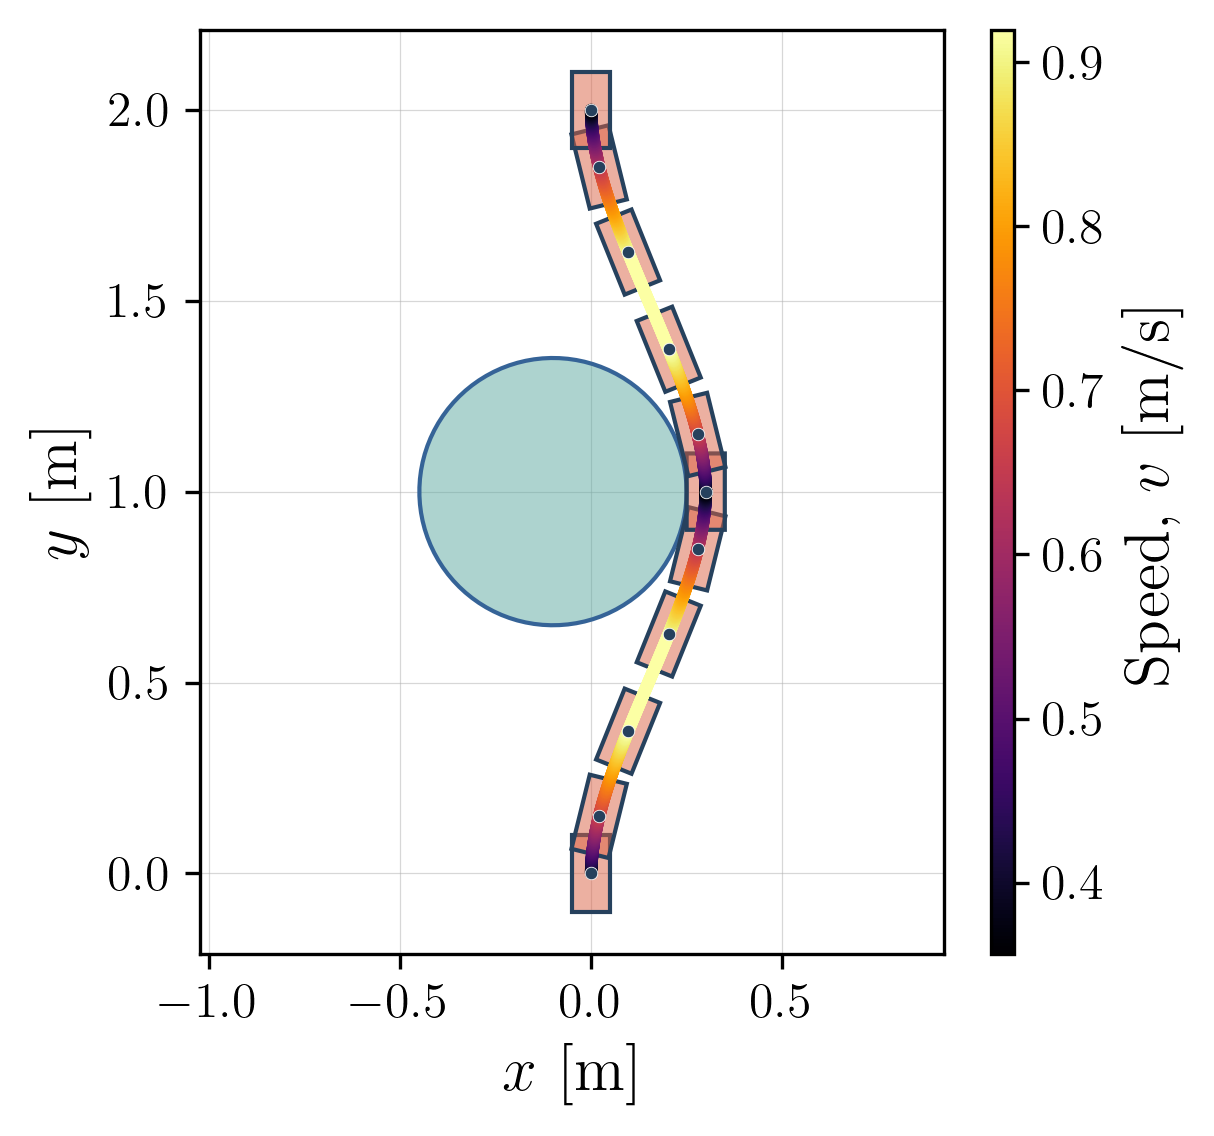

In [224]:
# Trajectory plot

PyPlot.svg(true)

ctres, overlap = 1000, 3
N = size(sol.xd, 2)
xct = hcat([sample(sol.xc, t) for t in LinRange(0, 1, ctres)]...)
vct = vcat([sample(sol.uc, t)[1] for t in LinRange(0, 1, ctres)]...)
cmap = generate_colormap("inferno"; minval=minimum(vct), maxval=maximum(vct))

# plot_options = Dict("xtick.labelsize"=>9,
#                     "ytick.labelsize"=>9,
#                     "axes.labelsize"=>11)
# fig = create_figure((4, 4); options = plot_options)

fig = plt.figure(figsize=(4,4), dpi=300)
plt.clf()
set_fonts()
set_fonts()

ax = setup_axis!(111, xlabel="\$x\$ [m]", ylabel="\$y\$ [m]",
                 axis="equal", cbar=cmap, clabel="Speed, \$v\$ [m/s]",
                 cbar_aspect=40)
ax.plot(sol.xd[1, :], sol.xd[2, :],
        linestyle="none", marker="o", markerfacecolor=DarkBlue,
        markeredgecolor="white", markeredgewidth=0.2, markersize=3,
        zorder=20)
line_segs = Vector{Matrix}(undef, 0)
line_clrs = Vector{NTuple{4, Real}}(undef, 0)
for k=1:ctres-overlap
    push!(line_segs, xct[1:2, k:k+overlap]')
    push!(line_clrs, cmap.to_rgba(vct[k]))
end
trajectory = PyPlot.matplotlib.collections.LineCollection(
    line_segs, zorder=10, colors = line_clrs, linewidths=3,
    capstyle="round")
ax.add_collection(trajectory)
Rect = PyPlot.matplotlib.patches.Rectangle
car_length = 0.2
for k=1:N
    local xl, xw = [1;1;-1;-1;1]*car_length/2, [1;-1;-1;1;1]*car_width/2
    local yl, yw = [1;1;-1;-1;1]*car_length/2, [-1;1;1;-1;-1]*car_width/2
    local ang = sol.xd[3,k]
    local xc = sol.xd[1,k].+xl.*sin(ang).+xw.*cos(ang)
    local yc = sol.xd[2,k].+yl.*cos(ang).+yw.*sin(ang)
    ax.fill(xc, yc,
            linewidth=1,
            edgecolor=DarkBlue,
            facecolor=rgb2pyplot(parse(RGB, Red), a=0.5),
            zorder=6)
end
ang = LinRange(0, 2*pi, 100)
obs = ([cos.(ang)'; sin.(ang)']*r_0).+c_0
ax.fill(obs[1, :], obs[2, :],
        linewidth=1,
        edgecolor=Blue,
        facecolor=rgb2pyplot(parse(RGB, Green), a=0.5),
        zorder=5)

plt.autoscale()
# fig.savefig("media/outputs/dubin_trajectory.png", bbox_inches="tight")

# plt.show()

<!-- <center>
    <img src="media/outputs/dubin_trajectory.png" width="500px"/>
    <br />
    <b>Figure.</b> Computed Dubin's car trajectory for minimum-input usage.
</center> -->